In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append(os.environ['DH_DIR'])

import numpy as np
import warnings

import darkhistory.physics as phys

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

In [2]:
# 1. compute total rate
# 2. compute distance travelled
# 3. branching ratio, branch to processes
# 4. scatter (or stop)

### Utilities

In [3]:
year = 365.25 * 86400 # [s]

In [4]:
def unit_vec(v):
    return v / np.linalg.norm(v)

def rand_unit_3vec():
    return unit_vec(np.random.default_rng().normal(size=3))

def lorentz_normsq(v): # [Mpc^2]
    return np.dot(v, v*np.array([-1, 1, 1, 1]))

def spatial_norm(v): # [Mpc^2]
    return np.sqrt(np.dot(v[1:], v[1:]))

def boost(v, bv):
    pass

### Particle

In [5]:
class Particle:
    
    def __init__(self, m0=None, x=np.array([0, 0, 0, 0]), v=np.array([1, 0, 0, 0]), name=''):
        
        if not m0:
            raise ValueError('must set m0!')
        self.m0 = m0 # [eV]
        self.x = x # [t, x, y, z] | [Mpc]
        self.v = v # [1, vx, vy, vz] | [1] | not four velocity
        self.name = name
        
        self.path = np.array([self.x])
        self.stopped = False
        
    def init_with_Ek(self, Ek): # None([eV])
        
        gamma = (Ek + self.m0) / self.m0
        beta = np.sqrt(1-1/gamma**2)
        self.v = np.array([1, beta, 0, 0])
        
    @property
    def beta(self):
        return spatial_norm(self.v)
    @property
    def gamma(self):
        return 1/np.sqrt(1-self.beta**2)
    @property
    def u(self): # four velocity
        return self.gamma * self.v
    @property
    def p(self):
        return self.m0 * self.u
    @property
    def E(self):
        return self.p[0]
    @property
    def Ek(self):
        return self.p[0] - self.m0
        
    def travel_to_x(self, x, v=None): # None([Mpc] [1])
        last_x = self.x
        self.x = x
        if v:
            self.v = v
        self.path = np.append(self.path, [self.x], axis=0)
        if last_x[0] > x[0]:
            warnings.warn(f"particle '{self.name}' going back in time!")
        if lorentz_normsq(x-last_x) > 0:
            warnings.warn(f"particle '{self.name}' going faster than light!")
            
    def travel_for(self, t): # None([Mpc])
        self.travel_to_x(self.x + self.v*t)
        
    def distance(self): # [Mpc]()
        return spatial_norm(self.path[-1] - self.path[0])
    
    def distance_traveled(self): # [Mpc]()
        segments = self.path[1:] - self.path[:-1]
        return np.sum([spatial_norm(s) for s in segments])
    
    def stop(self):
        #self.v = np.array([1, 0, 0, 0])
        self.stopped = True

### Processes

In [6]:
class CollisionHeatingProcess:
    
    def __init__(self, use_tcool_approx=False):
        self.use_tcool_approx = use_tcool_approx
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        Eek = pt.Ek
        xe = xHII if xHII else phys.xHII_std(rs) + phys.xHeII_std(rs)
        if self.use_tcool_approx:
            tcool = 5e3 * year * (1/xe) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
            rate = 1 / tcool
        else:
            dEdt = phys.elec_heating_engloss_rate(Eek, xe, rs) # [eV/s]
            rate = dEdt / Eek # [1/s]
        return rate
    
    def engloss_rate(self, *args, **kwargs):
        return self.total_rate(*args, **kwargs)
    
    def process(self, pt):
        pt.stop()

        
class IonizationProcess:
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        Eek = pt.Ek
        xHI = 1 - (xHII if xHII else phys.xHII_std(rs))
        tcool = 5e5 * year * (1/xHI) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
        return 1/tcool
    
    def engloss_rate(self, *args, **kwargs):
        return self.total_rate(*args, **kwargs)
    
    def process(self, pt):
        pt.stop()
        
        
class ExcitationProcess:
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        Eek = pt.Ek
        xHI = 1 - (xHII if xHII else phys.xHII_std(rs))
        tcool = 5e5 * year * (1/xHI) * (Eek/1e3)**(3/2) * (rs/10)**(-3)
        return 1/tcool
    
    def engloss_rate(self, *args, **kwargs):
        return self.total_rate(*args, **kwargs)
    
    def process(self, pt):
        pt.stop()
        
        
class ComptonProcess:
    
    def total_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        return phys.thomson_xsec * pt.beta * phys.c * phys.CMB_N_density(phys.TCMB(rs))
    
    def engloss_rate(self, pt, rs, xHII=None): # [s^-1](Particle, [1], [1])
        tcool = 1e8 * year * (rs/10)**(-4) / pt.gamma**2
        return 1/tcool
    
    def process(self, pt):
        pt.stop()

In [7]:
pt = Particle(m0=phys.me, name='electron')
pt.init_with_Ek(1e8)
c = ComptonProcess()
print(c.total_rate(pt, 1, xHII=0.9999))
print(c.engloss_rate(pt, 1, xHII=0.9999))

8.191251361392867e-12
1.225979484257738e-15


### MC simulate

In [8]:
from scipy import stats

In [9]:
Mpc = 3.08568e24 # cm
Mpc_per_s = Mpc / phys.c

In [16]:
process_list = [CollisionHeatingProcess(),
                IonizationProcess(),
                ExcitationProcess(),
                ComptonProcess()]

def simulate(Eek, rs, xHII=None, n_sim=1):
    
    pt_list = []
    
    for i_sim in range(n_sim):
        
        # create particle
        pt = Particle(m0=phys.me, name='electron')
        pt.init_with_Ek(Eek)
        
        while not pt.stopped:
            
            # travel under total rate
            rate_list = np.array([prc.total_rate(pt, rs, xHII=xHII) for prc in process_list])
            total_rate = np.sum(rate_list)
            mean_time = 1 / total_rate / Mpc_per_s
            rand_time = stats.expon.rvs(size=1, scale=mean_time)
            pt.travel_for(rand_time)
            
            # process particle
            prc = np.random.default_rng().choice(process_list, p=rate_list/np.sum(rate_list))
            prc.process(pt)
            
        # record particle
        pt_list.append(pt)
    
    return pt_list

## run

In [17]:
xHII = 0.9999
rs = 1
Eek_s = np.logspace(3, 9, 30)

In [18]:
dists_old = []
dists_mc = []
dists_mc_x = []

for i, Eek in enumerate(tqdm(Eek_s)):
    
    ## old plot
    pt = Particle(m0=phys.me, name='electron')
    pt.init_with_Ek(Eek)
    
    rate = np.sum([prc.engloss_rate(pt, rs, xHII=xHII) for prc in process_list])
    dist = pt.beta * phys.c * 1/rate / Mpc
    
    dists_old.append(dist)
    
    ## MC
    pt = Particle(m0=phys.me, name='electron')
    pt.init_with_Ek(Eek)
    
    pt_list = simulate(Eek, rs, xHII=xHII, n_sim=100)
    dists_mc.append(np.array([pt.distance() for pt in pt_list]))
    dists_mc_x.append(np.array([pt.Ek for pt in pt_list]))

  0%|          | 0/30 [00:00<?, ?it/s]

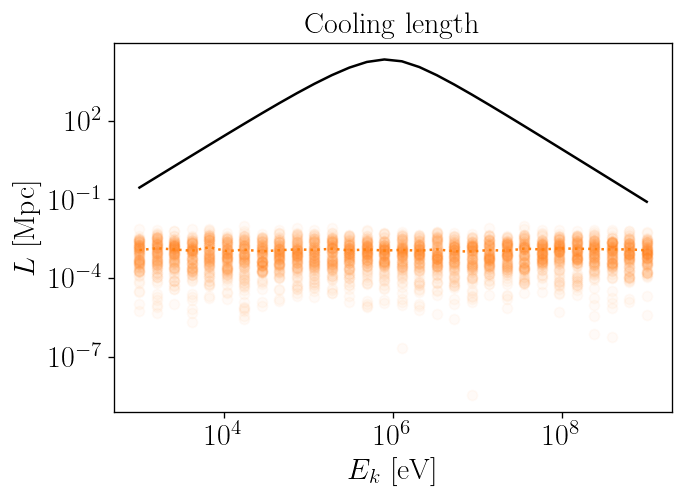

In [19]:
fig, ax = plt.subplots()

ax.plot(Eek_s, dists_old, color='k')
ax.scatter(np.array(dists_mc_x).flatten(), np.array(dists_mc).flatten(), c='C1', alpha=0.03)
ax.plot(Eek_s, [np.mean(dists) for dists in dists_mc], color='C1', linestyle=':')

ax.set(xscale='log', yscale='log')
ax.set(xlabel='$E_k$ [eV]', ylabel='$L$ [Mpc]', title='Cooling length');

![](tmp.png)

In [33]:
pt_list = simulate(1e6, 5)

  0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
def mean_distance(Eek, rs, xHII=None, n_sim=1000):
    pt_list = simulate(Eek, rs, xHII=xHII, n_sim=n_sim)
    return np.mean([pt.distance() for pt in pt_list])

In [37]:
mean_distance(1e6, 5)

149.00964819794387

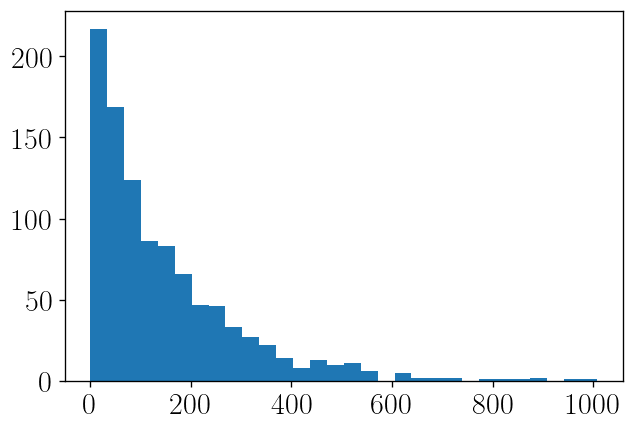

In [43]:
pt_list = simulate(1e6, 5, xHII=None, n_sim=1000)
plt.hist([pt.distance() for pt in pt_list], bins=30);